# **Introduction**




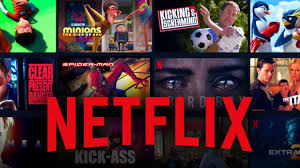 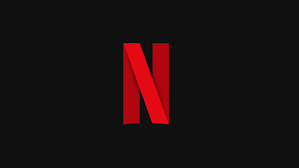
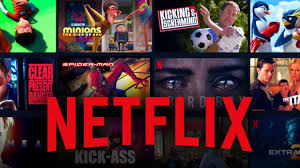

**Netflix** is one of the most popular media and video streaming platforms. They have over 8000 movies or tv shows available on their platform, as of mid-2021, they have over 200M Subscribers globally. This tabular dataset consists of listings of all the movies and tv shows available on Netflix, along with details such as - cast, directors, ratings, release year, duration, etc.

In this project, I am choosing a dataset of Netflix Movies and TV Shows on Kaggle, and my responsibilities are:



*   Conducting data analysis to investigate what content should we bring to our company, StreamFlicks'.
*   Conducting data analysis to look further on the trends of the content that Netflix add to their catalog.

# **Import Libraries**

In [ ]:
import pandas as pd
from scipy import stats
import numpy as np
import string

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import missingno as msno
import seaborn as sns
import plotly.express as px

import geopandas as gpd

import country_converter as coco

# ***Import Netflix Dataset***

In [ ]:
netflix = pd.read_csv('/content/netflix_titles.csv')

# **Understanding the data**

In [ ]:
#Display the first few rows
print(netflix.head())

  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021        

In [ ]:
netflix.info(verbose = True);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


From the .info() method, it is clear that our dataset still have missing data, so first of all, we need to handle this missing data carefully.


Missing data column:
*   director
*   cast
*   country
*   date_added
*   rating
*   duration








In [ ]:
netflix.describe(include=['object']).T.style.set_properties(
    **{'background-color': 'white',
       'color': 'black',
       'border-color': 'red'}
)

,count,unique,top,freq
show_id,8807,8807,s1,1
type,8807,2,Movie,6131
title,8807,8807,Dick Johnson Is Dead,1
director,6173,4528,Rajiv Chilaka,19
cast,7982,7692,David Attenborough,19
country,7976,748,United States,2818
date_added,8797,1767,"January 1, 2020",109
rating,8803,17,TV-MA,3207
duration,8804,220,1 Season,1793
listed_in,8807,514,"Dramas, International Movies",362


In [ ]:
netflix.describe(include=['number']).T.style.set_properties(
    **{'background-color': 'white',
       'color': 'black',
       'border-color': 'red'}
)

,count,mean,std,min,25%,50%,75%,max
release_year,8807.000000,2014.180198,8.819312,1925.000000,2013.000000,2017.000000,2019.000000,2021.000000


This two tables show some interesting stats:


1.   type - 2 categories, most of the content on the platform are movies.
2.   director - Rajiv Chilaka are contributed and directed as many as 19 titles, and on the top of the list. Some analyst use this value to fill missing values, but we are not considering that option and stick with missing values to director_data_unknown.
3.   cast - David Attenborough is the only actor to act in many of the films and shows on netflix. For missing values, we will use cast_data_unkown.
4.   country - United States is producing most of the content so far, so lets use this value to fillna values.
5.   date_added - January 1, 2020 is the peak where content most added.
6.   rating - 17 categories are present.
7.   listed_in - Dramas, International Movies are the most listed_in content.
8.   release_year - this is chronological time line of produced content, here range of content is from 1925 to 2021. This can help us see how popular content from years.
9.   descriptions - this can help us in understanding what kind of topics does content based on.







# **Data Preparation**

## Handling Missing Values

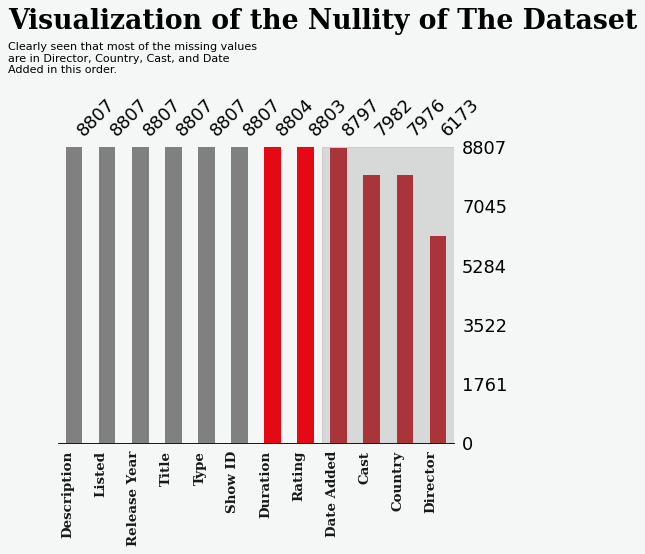

In [ ]:
# Visualization of the Nullity of the Dataset
fig, ax = plt.subplots(dpi=80)
ax.set_facecolor('#f5f6f6')
fig.patch.set_facecolor('#f5f6f6')

color = ['grey', 'grey', 'grey', 'grey', 'grey', 'grey', '#E50914', '#E50914', '#B81D24', '#B81D24', '#B81D24', '#B81D24']
msno.bar(netflix, fontsize=16, color=color, sort='descending', ax=ax, figsize=(12, 6))

labels = ['Description', 'Listed', 'Release Year', 'Title', 'Type', 'Show ID', 'Duration', 'Rating', 'Date Added', 'Cast', 'Country', 'Director']
ax.set_xticklabels(labels, fontdict={'font': 'serif', 'color': 'black', 'weight': 'bold', 'size': 12}, alpha=0.9, rotation=90)

ax.text(-2, 1.4, 'Visualization of the Nullity of The Dataset', {'font': 'serif', 'color': 'black', 'weight': 'bold', 'size': 24})
ax.text(-2, 1.25, 'Clearly seen that most of the missing values \nare in Director, Country, Cast, and Date \nAdded in this order.')
ax.axvspan(7.5, 12.5, color='grey', alpha=0.25)
ax.set_yticklabels('')
ax.spines['bottom'].set_visible(True)
plt.show()

filling missing data values with following datapoints:
1. director - NoDataAvailable
2. country - made of the country series
3. cast - NoDataAvailable
4. date_added - mode of the date_added
5. rating - mode of the rating
6. duration - mode of the duration split by movies and tvshow duration

In [ ]:
netflix_orig = netflix.copy() # copying original dataset

# handling missing values
netflix['director'] = netflix['director'].fillna('NoDataAvailable')
netflix['country'] = netflix['country'].fillna(netflix['country'].mode()[0])
netflix['cast'] = netflix['cast'].fillna('NoDataAvailable')
netflix['date_added'] = netflix['date_added'].fillna(netflix['date_added'].mode()[0])
netflix['rating'] = netflix['rating'].fillna(netflix['rating'].mode()[0])

# Separate masks for movies and TV shows
movies_mask = netflix['type'] == 'Movie'
tvshows_mask = netflix['type'] == 'TV Show'

# Handle missing values for 'duration' based on type
netflix.loc[movies_mask, 'duration'] = netflix.loc[movies_mask, 'duration'].fillna(netflix[movies_mask]['duration'].mode()[0])
netflix.loc[tvshows_mask, 'duration'] = netflix.loc[tvshows_mask, 'duration'].fillna(netflix[tvshows_mask]['duration'].mode()[0])

print('count of values')
print(netflix.isna().sum())

count of values
show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64


In [ ]:
netflix.info(verbose = True);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      8807 non-null   object
 4   cast          8807 non-null   object
 5   country       8807 non-null   object
 6   date_added    8807 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8807 non-null   object
 9   duration      8807 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


***Successfully handled all missing values in Netflix dataset!***

##Handling Duplicate Values

In [ ]:
netflix.duplicated().any()

False

There is no any duplicate values in this dataset. It can be shown from the show_id column where all the rows is unique.

# **Exploratory Data Analysis**

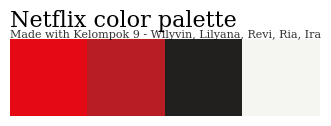

In [ ]:
#Netflix brand colors
colors = ['#E50914', '#B81D24', '#221F1F', '#F5F5F1'] #red, dark red, black, tan

sns.palplot(colors, size = 1)
plt.title("Netflix color palette", loc = 'left', fontfamily = 'Serif', fontsize = 16, y = 1.05)
plt.text(-0.5,-0.52, 'Made with Kelompok 9 - Wilyvin, Lilyana, Revi, Ria, Ira',{'font':'serif', 'color':'black','weight':'normal','size':8}, alpha = 0.8 )
plt.axis('off')
fig.show()

##Movies vs TV Shows Preferences on Netflix



In [ ]:
x = netflix['type'].value_counts()
x

type
Movie      6131
TV Show    2676
Name: count, dtype: int64

In [ ]:
x_percentage = netflix['type'].value_counts(normalize = True) * 100
x_percentage = x_percentage.round(2).astype(str)+'%'
x_percentage_df = x_percentage.reset_index()
x_percentage_df.columns = ['Type', 'Percentage']

#Apply style properties for dataframe
styled_df = x_percentage_df.style.set_properties(**{
    'background-color': '#F5F5F1',  # Warna latar belakang
    'color': '#B81D24',                 # Warna teks
    'border-color': '#221F1F',          # Warna batas
    'border-width': '2px',            # Lebar batas
    'border-style': 'solid'           # Gaya batas
})
styled_df

,Type,Percentage
0,Movie,69.62%
1,TV Show,30.38%


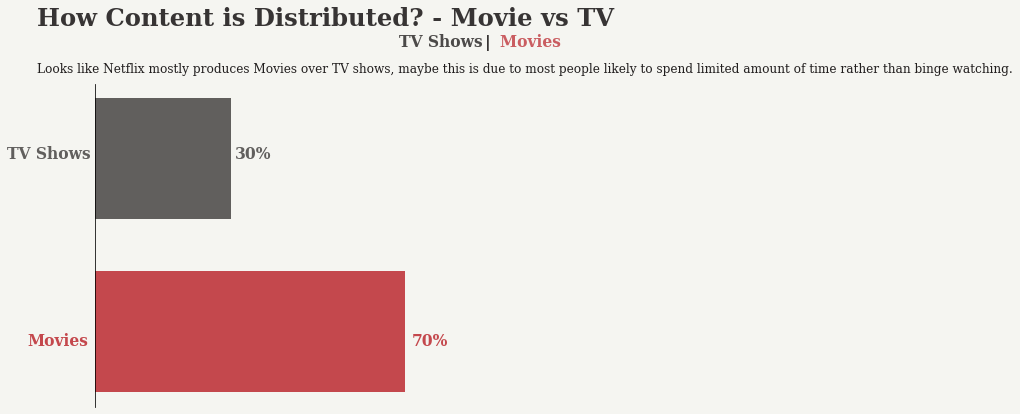

In [ ]:
x = netflix['type'].value_counts()

#plot
fig, ax = plt.subplots(figsize=(6, 6), dpi=70)

#Movies Horizontal Barchart
ax.barh([0], x.values[0], height=0.7, color='#B81D24', alpha=0.8)
plt.text(-1350, -0.08, 'Movies', {'font': 'Serif', 'weight': 'bold', 'size': '16', 'style': 'normal', 'color': '#B81D24'}, alpha=0.8)
plt.text(6250, -0.08, '70%', {'font': 'Serif', 'weight': 'bold', 'size': '16', 'color': '#B81D24'}, alpha=0.8)

#TV Shows Horizontal Barchart
ax.barh([1], x.values[1], height=0.7, color='#221F1F', alpha=0.7)
plt.text(-1750, 1, 'TV Shows', {'font': 'Serif', 'weight': 'bold', 'size': '16', 'style': 'normal', 'color': '#221F1F'}, alpha=0.7)
plt.text(2750, 1, '30%', {'font': 'Serif', 'weight': 'bold', 'size': '16', 'color': '#221F1F'}, alpha=0.7)

fig.patch.set_facecolor('#F5F5F1')
ax.set_facecolor('#F5F5F1')

#Background and additional text
plt.text(-1150, 1.77, 'How Content is Distributed? - Movie vs TV', {'font': 'Serif', 'size': '25', 'weight': 'bold', 'color': '#221F1F'}, alpha=0.9)
plt.text(6000, 1.65, 'TV Shows', {'font': 'Serif', 'weight': 'bold', 'size': '16', 'color': '#221F1F'}, alpha=0.8)
plt.text(7700, 1.65, '|', {'color': '#221F1F', 'size': '16', 'weight': 'bold'}, alpha=0.9)
plt.text(8000, 1.65, 'Movies ', {'font': 'Serif', 'weight': 'bold', 'size': '16', 'color': '#B81D24'}, alpha=0.7)
plt.text(-1150, 1.5, 'Looks like Netflix mostly produces Movies over TV shows, maybe this is due to most people likely to spend limited amount of time rather than binge watching.', {'font': 'Serif', 'size': '12.5', 'color': '#221F1F'})

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()


From this analysis and visualization, we can said Netflix offer two kind of streaming content for the users, which are **Movies and TV shows**.

> Distribution of the content shows ***Movies is at the top of Netflix content***, which occupy nearly **70%** of the content it offer.




---


Let's look further to content released and added year analysis if there are any changes over the time.

In [ ]:
TV = netflix[netflix['type'] == 'TV Show'].release_year.value_counts()
Movie = netflix[netflix['type'] == 'Movie'].release_year.value_counts()

# creating a dataframe

Tv_df = pd.DataFrame({'year': TV.index, 'Tv_count': TV.values})
Movie_df = pd.DataFrame({'year': Movie.index, 'Movie_count': Movie.values})

rel_data = pd.merge(Tv_df, Movie_df, how = 'right', on = 'year')
rel_data.fillna('0', inplace = True)
rel_data['Tv_count'] = rel_data.Tv_count.astype('int64')
rel_data = rel_data.sort_values('year', ascending = False).reset_index(drop = True)

In [ ]:
Movie_dfs = Movie_df.sort_values(by='year', ascending=False).reset_index(drop=True)
Movie_dfs

,year,Movie_count
0,2021,277
1,2020,517
2,2019,633
3,2018,767
4,2017,767
...,...,...
68,1946,1
69,1945,3
70,1944,3
71,1943,3


In [ ]:
Tv_dfs = Tv_df.sort_values(by='year', ascending=False).reset_index(drop=True)
Tv_dfs

,year,Tv_count
0,2021,315
1,2020,436
2,2019,397
3,2018,380
4,2017,265
5,2016,244
6,2015,162
7,2014,88
8,2013,63
9,2012,64


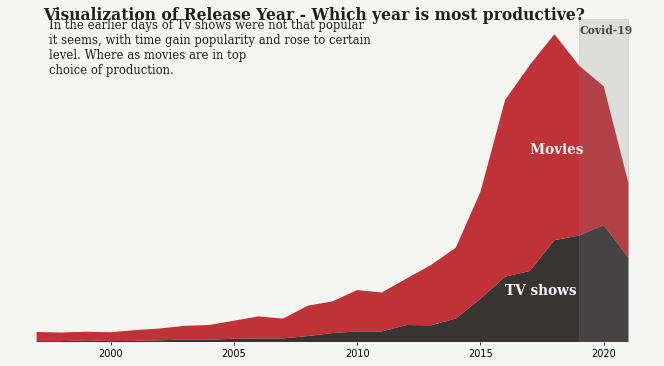

In [ ]:
## visualization

fig, ax = plt.subplots(figsize = (12,6), dpi = 70)
fig.patch.set_facecolor('#F5F5F1')
ax.set_facecolor('#F5F5F1')

labels = [ 'TV shows', 'Movies ']

# stackplot
ax.stackplot(rel_data.year[0:25], rel_data.Tv_count[0:25],rel_data.Movie_count[0:25],labels =labels,
              colors = ['#221F1F','#B81D24',], baseline = 'zero', alpha = 0.9 )

# Region of interest

ax.axvspan(2019,2021, color = 'grey',alpha = 0.2)
ax.text(2019, 1147, 'Covid-19', {'font':'serif', 'fontsize': '11', 'color': '#221F1F', 'weight':'bold'},alpha = 0.8)

# legend
ax.text(2017, 700, '{}'.format(labels[1]), {'font':'serif', 'fontsize':'14', 'color':'#f6f5f5', 'weight':'bold'})
ax.text(2016, 175, '{}'.format(labels[0]),{'font':'serif', 'fontsize':'14', 'color':'#f6f5f5','weight':'bold'})

#title

ax.text(1997.25,1200, 'Visualization of Release Year - Which year is most productive?',
                      {'font':'serif', 'fontsize':'16', 'weight': 'bold','color': '#221F1F'})
ax.text(1997.5,1000, 'In the earlier days of Tv shows were not that popular \nit seems, with time gain popularity and rose to certain \nlevel. Where as movies are in top \nchoice of production. ',
                      {'font':'serif', 'fontsize':'12','color': '#221F1F'})

plt.box(on = None)

ax.axes.get_yaxis().set_visible(False)
fig.show()

In [ ]:
netflix['date_added'] = pd.to_datetime(netflix['date_added'], errors='coerce')
netflix['added_year'] = netflix['date_added'].dt.year
TV = netflix[netflix['type'] == 'TV Show'].added_year.value_counts()
Movie = netflix[netflix['type'] == 'Movie'].added_year.value_counts()

# creating a dataframe

Tv_df = pd.DataFrame({'year': TV.index, 'Tv_count': TV.values})
Movie_df = pd.DataFrame({'year': Movie.index, 'Movie_count': Movie.values})

add_data = pd.merge(Tv_df, Movie_df, how = 'right', on = 'year')
add_data.fillna('0', inplace = True)
add_data['Tv_count'] = add_data.Tv_count.astype('int64')
add_data = add_data.sort_values('year', ascending = False).reset_index(drop = True)

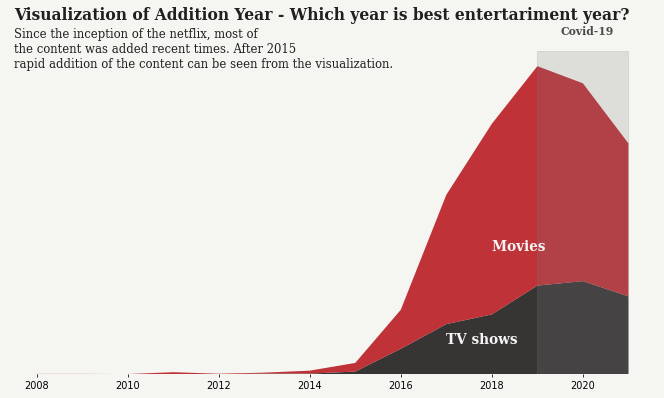

In [ ]:
## visualization

fig, ax = plt.subplots(figsize = (12,6), dpi = 70)
fig.patch.set_facecolor('#F5F5F1')
ax.set_facecolor('#F5F5F1')

labels = [ 'TV shows', 'Movies ']

# stackplot
ax.stackplot(add_data.year[0:25], add_data.Tv_count[0:25],add_data.Movie_count[0:25],labels =labels,
              colors = ['#221F1F','#B81D24',], baseline = 'zero', alpha = 0.9 )

# Region of interest

ax.axvspan(2019,2021, color = 'grey',alpha = 0.2)
ax.text(2019.5, 2200, 'Covid-19', {'font':'serif', 'fontsize': '11', 'color': '#221F1F', 'weight':'bold'},alpha = 0.8)

# legend
ax.text(2018, 800,'{}'.format(labels[1]), {'font':'serif', 'fontsize':'14', 'color':'#f6f5f5', 'weight':'bold'})
ax.text(2017, 200, '{}'.format(labels[0]),{'font':'serif', 'fontsize':'14', 'color':'#f6f5f5','weight':'bold'})

#title

ax.text(2007.5,2300, 'Visualization of Addition Year - Which year is best entertariment year?',
                      {'font':'serif', 'fontsize':'16', 'weight': 'bold','color': '#221F1F'})
ax.text(2007.5,1990, 'Since the inception of the netflix, most of \nthe content was added recent times. After 2015 \nrapid addition of the content can be seen from the visualization. ',
                      {'font':'serif', 'fontsize':'12','color': '#221F1F'})

plt.box(on = None)

ax.axes.get_yaxis().set_visible(False)
fig.show()

> From visualization of release year and addition year, it shows that Netflix has been focusing more on increasing Movie content compared to TV Shows.


---

Let's explore about **"What month has the most content added?"**

In [ ]:
netflix['date_added'] = pd.to_datetime(netflix['date_added'], errors='coerce')
netflix['added_month'] = netflix['date_added'].dt.month
TV = netflix[netflix['type'] == 'TV Show'].added_month.value_counts()
Movie = netflix[netflix['type'] == 'Movie'].added_month.value_counts()

# creating a dataframe

Tv_df = pd.DataFrame({'month': TV.index, 'Tv_count': TV.values})
Movie_df = pd.DataFrame({'month': Movie.index, 'Movie_count': Movie.values})

add_data = pd.merge(Tv_df, Movie_df, how='outer', on='month')
add_data.fillna('0', inplace = True)
add_data['Tv_count'] = add_data.Tv_count.astype('int64')
add_data = add_data.sort_values('month', ascending=False).reset_index(drop=True)
add_data

,month,Tv_count,Movie_count
0,12.0,250,547
1,11.0,199,498
2,10.0,210,545
3,9.0,246,519
4,8.0,230,519
5,7.0,254,565
6,6.0,232,492
7,5.0,187,439
8,4.0,209,550
9,3.0,205,529


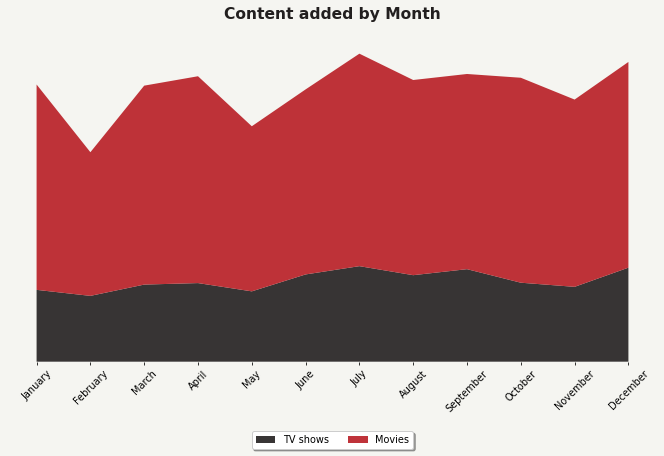

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=70)
fig.patch.set_facecolor('#F5F5F1')
ax.set_facecolor('#F5F5F1')

labels = ['TV shows', 'Movies']

# Stackplot
ax.stackplot(add_data.month, add_data.Tv_count, add_data.Movie_count, labels=labels,
             colors=['#221F1F', '#B81D24'], baseline='zero', alpha=0.9)

#title
ax.set_title('Content added by Month', pad=20, fontsize=16, fontweight='bold', color='#221F1F')
months = ['December', 'November', 'October', 'September', 'August', 'July',
          'June', 'May', 'April', 'March', 'February', 'January']
plt.xticks(add_data.month, labels=months, rotation=45)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=True, ncol=2)
plt.box(on=None)

ax.axes.get_yaxis().set_visible(False)
plt.show()

As we can see from this above visualization, Holiday seasons - January, July, and December seem to be the best month for the added of new content on Netflix.



> Netflix knows its customers' time-spending habits, also Netflix strategy is tend to adds more Movies during the second half of the year, start from July until December.



> TV Shows same like Movies, but their amount are less in quantity.





## Netflix Content Distribution by Country: Movies vs TV Shows

Top 10 Countries as Netflix Content Producer

In [ ]:
country_counts = netflix['country'].value_counts()

top_10_countries = country_counts.nlargest(10)

top_10_countries_df = top_10_countries.reset_index()
top_10_countries_df.columns = ['Country', 'Content Amount']

#Apply style properties for dataframe
styled_df = top_10_countries_df.style.set_properties(**{
    'background-color': '#F5F5F1',  # Warna latar belakang
    'color': '#B81D24',                 # Warna teks
    'border-color': '#221F1F',          # Warna batas
    'border-width': '2px',            # Lebar batas
    'border-style': 'solid'           # Gaya batas
})
styled_df

,Country,Content Amount
0,United States,3649
1,India,972
2,United Kingdom,419
3,Japan,245
4,South Korea,199
5,Canada,181
6,Spain,145
7,France,124
8,Mexico,110
9,Egypt,106


<ipython-input-22-8bb93fb98931>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(top_10_countries.index, rotation=45, ha='right')


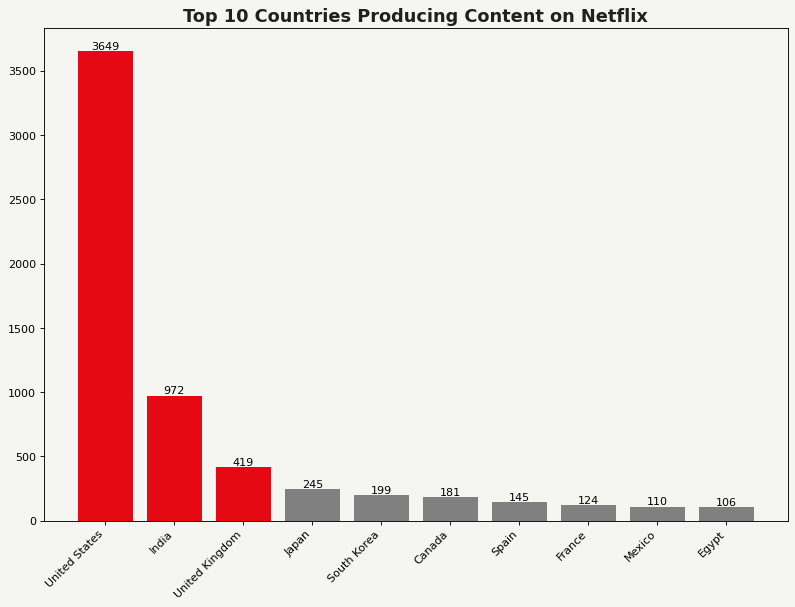

In [ ]:
# Menentukan warna untuk setiap bar
colors = ['#E50914', '#E50914', '#E50914', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey']

# Plotting
fig, ax = plt.subplots(figsize=(12, 8), dpi=80)
fig.patch.set_facecolor('#F5F5F1')
ax.set_facecolor('#F5F5F1')

bars = ax.bar(top_10_countries.index, top_10_countries.values, color=colors)
ax.set_title('Top 10 Countries Producing Content on Netflix', fontsize=16, fontweight='bold', color='#221F1F')

# Menambahkan nilai pada setiap bar
for bar in bars:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
            f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=10, color='black')

# Memutar label sumbu x
ax.set_xticklabels(top_10_countries.index, rotation=45, ha='right')

plt.show()



> Numerically, US is on the top of list, followed by India and United Kingdom as the second and third of content (Movies & TV Shows) producer.


---

Let's explore content separately for TV Shows and Movies to see which country favour to what type of the content most.




###TV Shows countrywise distribution

In [ ]:
TV = netflix[netflix['type'] == 'TV Show']

TV_country = TV.country.value_counts()

top_10_country_bytvshows = TV_country.nlargest(10)

top_10_country_bytvshows_df = top_10_country_bytvshows.reset_index()
top_10_country_bytvshows_df.columns = ['Country', 'TV']

#Apply style properties for dataframe
styled_df = top_10_country_bytvshows_df.style.set_properties(**{
    'background-color': '#F5F5F1',  # Warna latar belakang
    'color': '#B81D24',                 # Warna teks
    'border-color': '#221F1F',          # Warna batas
    'border-width': '2px',            # Lebar batas
    'border-style': 'solid'           # Gaya batas
})
styled_df

,Country,TV
0,United States,1151
1,United Kingdom,213
2,Japan,169
3,South Korea,158
4,India,79
5,Taiwan,68
6,Canada,59
7,France,49
8,Australia,48
9,Spain,48




> As we can see from this table, Taiwan and Australia users prefer TV shows over films, possibly because streaming users prefer episodic films over short films.



> So more TV show content is produced in these two countries.




<ipython-input-40-dd74446deb45>:29: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/usr/local/lib/python3.10/dist-packages/geopandas/plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


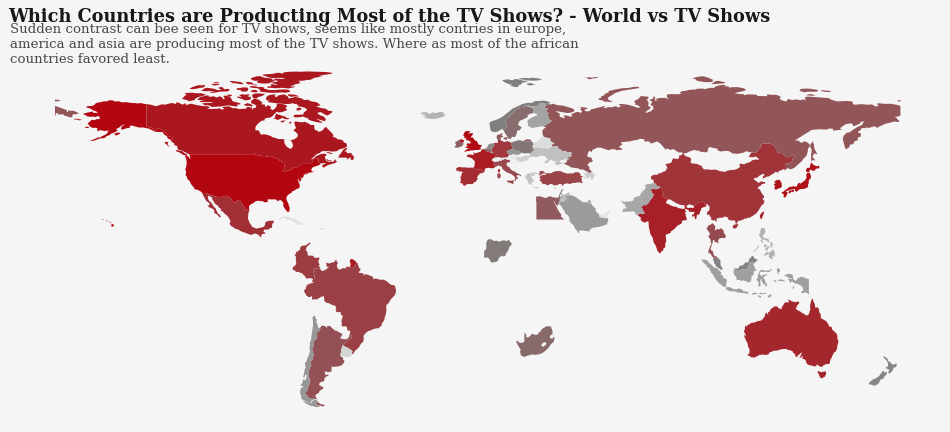

In [ ]:
## TV Shows countrywise distribution
TV_country = TV.country.value_counts()

TV_coun = {}
for idx, val in TV_country.items():
    l = idx.split(',')
    for i in l:
        i = i.strip()
        if i in TV_coun.keys():
            d = {}
            d[i] = val + TV_coun[i]
            TV_coun.update(d)
        else:
            d = {i:val}
            TV_coun.update(d)

TV_nation, TV_count = [],[]
for idx, val in TV_coun.items():
    TV_nation.append(idx)
    TV_count.append(val)

TV_temp = (pd.DataFrame({'country':TV_nation, 'count': TV_count})
        .sort_values('count', ascending = False))
TV_temp['color'] = TV_temp['count'].apply(lambda x : '#b20710' if x > TV_temp['count'].values[3] else 'grey')

#--------------------
TV_temp['color'] = TV_temp['count'].apply(lambda x : '#b20710' if x > TV_temp['count'].values[30] else 'grey')

#loading geodataframe
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#converting country names to iso codes
TV_temp['iso_code'] = coco.convert(names=TV_temp['country'], to ='ISO3')
TV_temp = TV_temp[TV_temp['iso_code'] != 'not found']

# merging geodataframe and pandas dataframe
temp_map = world.merge(TV_temp,left_on = 'iso_a3', right_on = 'iso_code')

temp_map.drop(columns = ['continent', 'gdp_md_est','pop_est','name',], inplace = True)
temp_map = temp_map.sort_values(by = 'count', ascending = False)


#viualization
colors = ['#b20710','grey','#f8f9f9',]
cmap  = matplotlib.colors.LinearSegmentedColormap.from_list("", colors = colors)

fig, ax  = plt.subplots(figsize = (15,7.5), dpi = 80)
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')
temp_map.dropna().plot(column = 'count',
                       color = temp_map.dropna()['color'],
                       cmap = cmap,
                       scheme='quantiles',
                       k=10, legend = False,
                       ax = ax)

for loc in ['left','right','top','bottom']:
    ax.spines[loc].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

ax.text(-200,104,'Which Countries are Producting Most of the TV Shows? - World vs TV Shows', {'font':'serif', 'size':16, 'weight':'bold'}, alpha = 0.9)
ax.text(-199,87,'Sudden contrast can bee seen for TV shows, seems like mostly contries in europe, \namerica and asia are producing most of the TV shows. Where as most of the african \ncountries favored least.', {'font':'serif', 'size':12}, alpha = 0.7)
fig.show()

###Movies countrywise distribution

In [ ]:
Movie = netflix[netflix['type'] == 'Movie']

Movie_country = Movie.country.value_counts()

top_10_country_bymovie = Movie_country.nlargest(10)

top_10_country_bymovie_df = top_10_country_bymovie.reset_index()
top_10_country_bymovie_df.columns = ['Country', 'Movie']

#Apply style properties for dataframe
styled_df = top_10_country_bymovie_df.style.set_properties(**{
    'background-color': '#F5F5F1',  # Warna latar belakang
    'color': '#B81D24',                 # Warna teks
    'border-color': '#221F1F',          # Warna batas
    'border-width': '2px',            # Lebar batas
    'border-style': 'solid'           # Gaya batas
})
styled_df

,Country,Movie
0,United States,2498
1,India,893
2,United Kingdom,206
3,Canada,122
4,Spain,97
5,Egypt,92
6,Nigeria,86
7,Indonesia,77
8,Turkey,76
9,Japan,76




>





> While from this Movie table, Country like Spain, Nigeria, Indonesia, and Turkey users prefer Movies over TV Shows.



> So more Movies content is produced in these countries.





<ipython-input-42-e447fbd674dc>:32: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/usr/local/lib/python3.10/dist-packages/geopandas/plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


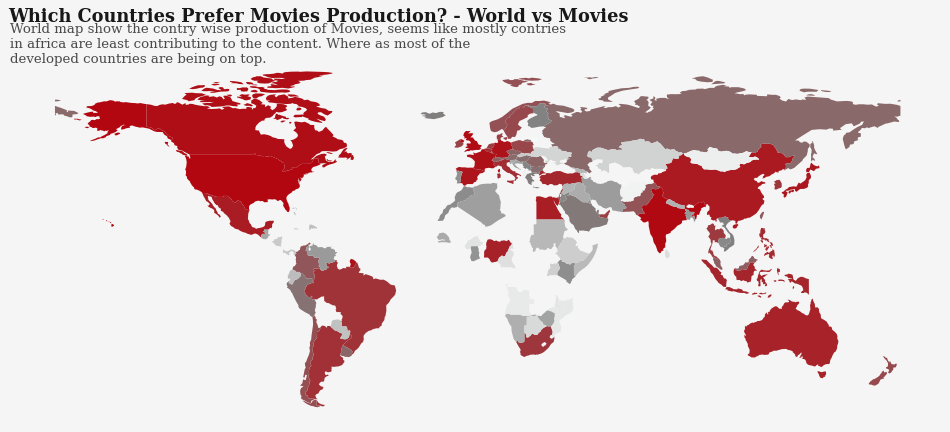

In [ ]:
## Movies countrywise distribution
Movi_country = Movie.country.value_counts()

Movi_coun = {}
for idx, val in Movi_country.items():
    l = idx.split(',')
    for i in l:
        i = i.strip()
        if i in Movi_coun.keys():
            d = {}
            d[i] = val + Movi_coun[i]
            Movi_coun.update(d)
        else:
            d = {i:val}
            Movi_coun.update(d)

Movi_nation, Movi_count = [],[]
for idx, val in Movi_coun.items():
    Movi_nation.append(idx)
    Movi_count.append(val)

Movi_temp = (pd.DataFrame({'country':Movi_nation, 'count': Movi_count})
        .sort_values('count', ascending = False))

Movi_temp['color'] = Movi_temp['count'].apply(lambda x : '#b20710' if x > Movi_temp['count'].values[3] else 'grey')

#--------------------------
temp = Movi_temp
temp['color'] = temp['count'].apply(lambda x : '#b20710' if x > temp['count'].values[30] else 'grey')

#loading geodataframe
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#converting country names to iso codes
temp['iso_code'] = coco.convert(names=temp['country'], to ='ISO3')
temp = temp[temp['iso_code'] != 'not found']

# merging geodataframe and pandas dataframe
temp_map = world.merge(temp,left_on = 'iso_a3', right_on = 'iso_code')

temp_map.drop(columns = ['continent', 'gdp_md_est','pop_est','name',], inplace = True)
temp_map = temp_map.sort_values(by = 'count', ascending = False)


#viualization
colors = ['#b20710','grey','#f8f9f9',]
cmap  = matplotlib.colors.LinearSegmentedColormap.from_list("", colors = colors)

fig, ax  = plt.subplots(figsize = (15,7.5), dpi = 80)
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')
temp_map.dropna().plot(column = 'count',
                       color = temp_map.dropna()['color'],
                       cmap = cmap,
                       scheme='quantiles',
                       k=10, legend = False,
                       ax = ax)

for loc in ['left','right','top','bottom']:
    ax.spines[loc].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

ax.text(-200,104,'Which Countries Prefer Movies Production? - World vs Movies', {'font':'serif', 'size':16, 'weight':'bold'}, alpha = 0.9)
ax.text(-199,87,'World map show the contry wise production of Movies, seems like mostly contries \nin africa are least contributing to the content. Where as most of the \ndeveloped countries are being on top.', {'font':'serif', 'size':12}, alpha = 0.7)
fig.show()

>Because Movies is the most content release, added, and distributed by country.
Let's explore further on **`Movies based on IMDB Ratings`**.



> **🎥🎞** -> Yes, we want to explore Movies!!

>**📺** -> No, we won't explore IMDB ratings for TV Shows!



##Movies based on IMDB Ratings

###Import IMDB Movies and Ratings File

In [ ]:
imdb_ratings=pd.read_csv('/content/IMDb ratings.csv',usecols=['weighted_average_vote'])
imdb_titles=pd.read_csv('/content/IMDb movies.csv', usecols=['title','year','genre'])
ratings = pd.DataFrame({'Title':imdb_titles.title,
                    'Release Year':imdb_titles.year,
                    'Rating': imdb_ratings.weighted_average_vote,
                    'Genre':imdb_titles.genre})
ratings.drop_duplicates(subset=['Title','Release Year','Rating'], inplace=True)
ratings.shape

<ipython-input-47-c61e8664e294>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb_titles=pd.read_csv('/content/IMDb movies.csv', usecols=['title','year','genre'])


(85838, 4)

Performing inner join on the ratings dataset and netflix dataset so we can get movies that has ratings on IMDb and are available on Netflix.

In [ ]:
ratings.dropna()
joint_data=ratings.merge(netflix,left_on='Title',right_on='title',how='inner')
joint_data=joint_data.sort_values(by='Rating', ascending=False)

###Table & Visualization

Top 100 rated Movies on Netflix

In [ ]:
joint_datas = joint_data.nlargest(101, 'Rating')

joint_data_df = joint_datas.reset_index()
joint_data_df = joint_data_df[['Title', 'Rating']]

#Apply style properties for dataframe
styled_df = joint_data_df.style.set_properties(**{
    'background-color': '#F5F5F1',  # Warna latar belakang
    'color': '#B81D24',             # Warna teks
    'border-color': '#221F1F',      # Warna batas
    'border-width': '2px',          # Lebar batas
    'border-style': 'solid'         # Gaya batas
})

styled_df

,Title,Rating
0,Breakout,9.000000
1,Pulp Fiction,8.900000
2,Schindler's List,8.900000
3,Inception,8.800000
4,Oththa Seruppu Size 7,8.600000
5,Koshish,8.600000
6,Eh Janam Tumhare Lekhe,8.600000
7,Gol Maal,8.600000
8,Seven,8.600000
9,City of God,8.600000


Visualize Top 10 rated Movies on Netflix

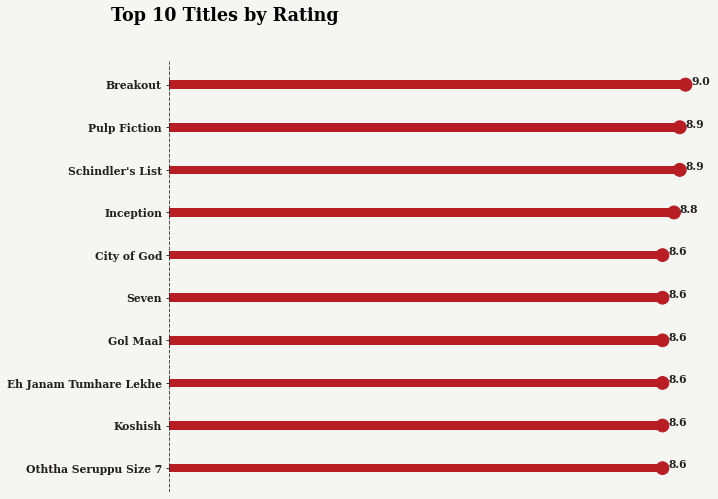

In [ ]:
# Urutkan berdasarkan Rating secara menurun
joint_data_df = joint_data_df.sort_values(by='Rating', ascending=True)

# Ambil 10 judul pertama
joint_data_df = joint_data_df.head(10)

# Plotting
fig, ax = plt.subplots(figsize=(10, 8), dpi=70)
fig.patch.set_facecolor('#F5F5F1')
ax.set_facecolor('#F5F5F1')

# Horizontal bar chart
ax.barh(y=range(1, len(joint_data_df)+1), width=joint_data_df['Rating'], height=0.2, color='#B81D24')
ax.scatter(y=range(1, len(joint_data_df)+1), x=joint_data_df['Rating'], s=joint_data_df['Rating'] * 20, c='#B81D24')
ax.axvline(x=0, ymin=0, ymax=1, linewidth=1, linestyle='--', color='#221F1F', alpha=0.8)

# Teks untuk setiap bar
for i, (index, row) in enumerate(joint_data_df.iterrows()):
    ax.text(row['Rating'] + 0.1, i+1, f"{row['Rating']}", {'font': 'serif', 'size': 11, 'weight': 'bold', 'color' : '#221F1F'})

# Label sumbu y
ax.set_yticks(range(1, len(joint_data_df)+1))
ax.set_yticklabels(joint_data_df['Title'], fontdict={'font': 'serif', 'size': 11, 'weight': 'bold', 'color' : '#221F1F'})

# Menghapus ticks dan labels pada sumbu x
ax.set_xticks([])
ax.set_xticklabels([])

# Judul
ax.text(-1, len(joint_data_df)+1.5, 'Top 10 Titles by Rating', {'font': 'serif', 'size': 18, 'weight': 'bold'})

# Hapus kotak frame
plt.box(on=None)

# Tampilkan plot
plt.show()

In [ ]:
top_rated=joint_data[0:10]
fig =px.sunburst(
    top_rated,
    path=['title','country'],
    values='Rating',
    color='Rating',
    color_continuous_scale='reds')
fig.update_traces(textinfo='label')

fig.show()



> The film entitled "Breakout" is in first place as the film with the highest rating at 9.0, followed by "Pulp Fiction" and "Inception" at 8.9.



---



> From the pie chart above, it can be concluded that the countries that have films with the highest ratings are the **United States and India**, which occupy almost all of the top 10. This shows that the quality of films produced by these two countries is beyond doubt, especially since there are the largest industries, namely **Hollywood** in California, United States and **Bollywood** in Mumbai, India.







##Movies and TV Shows Genres

Netflix offer range of genre to user, it would be fun to analyze this feature.

In [ ]:
## genere count

def genere(what):
    if what == 'all':
        genere = netflix.listed_in.value_counts()
    else:
        genere = netflix[netflix['type'] == what].listed_in.value_counts()
    gener = {}

    for idx, val in genere.items():
        l = idx.split(',')
        for i in l:
            i = i.strip()
            if i in gener.keys():
                d = {}
                d[i] = val + gener[i]
                gener.update(d)
            else:
                d = {i:val}
                gener.update(d)
    theme, count = [],[]

    for idx, val in gener.items():
        theme.append(idx)
        count.append(val)

    list_temp = (pd.DataFrame({'genere':theme, 'count': count})
        .sort_values('count', ascending = True))
    list_temp.reset_index(drop = True, inplace = True)

    return list_temp
tv_genere = genere('TV Show')
mov_genere = genere('Movie')

###*Movie Genre*



In [ ]:
mov_genere.sort_values(by='count', ascending = False)

,genere,count
19,International Movies,2752
18,Dramas,2427
17,Comedies,1674
16,Documentaries,869
15,Action & Adventure,859
14,Independent Movies,756
13,Children & Family Movies,641
12,Romantic Movies,616
11,Thrillers,577
10,Music & Musicals,375


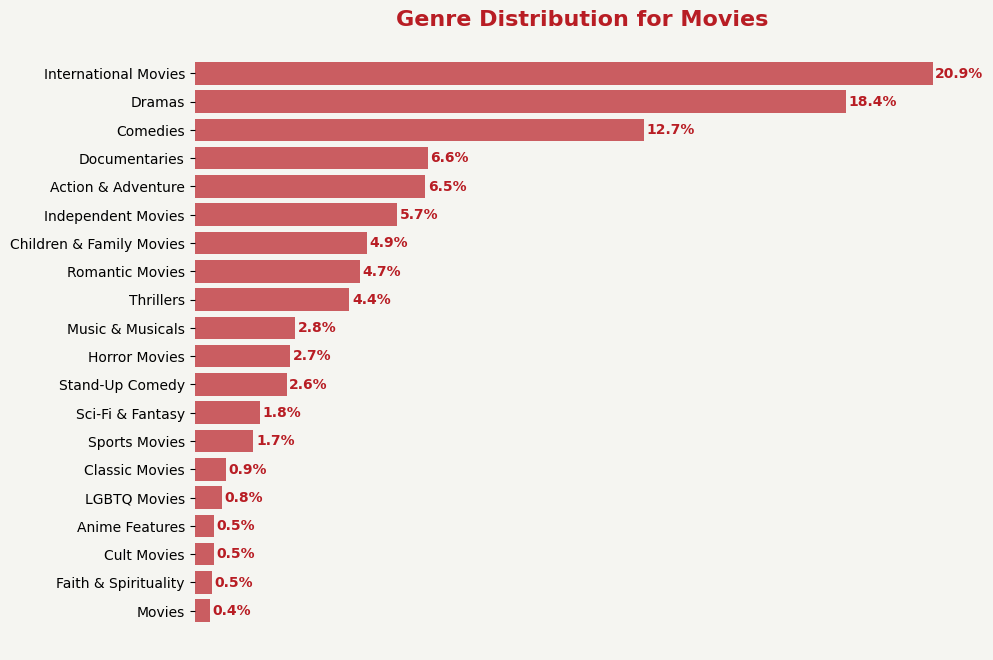

In [ ]:
def plot_genre(data, title, color):
    fig, ax = plt.subplots(figsize=(10, 8))
    fig.patch.set_facecolor('#F5F5F1')
    ax.set_facecolor('#F5F5F1')
    bars = ax.barh(data['genere'], data['count'], color='#B81D24', alpha=0.7)
    ax.set_title(title, fontsize=20, fontweight='bold', color='#B81D24')  # Ubah ukuran dan warna judul
    ax.set_title(title, fontsize=16, fontweight='bold')

    total = data['count'].sum()
    # Adding label in the right of the bar
    for bar in bars:
        percentage = bar.get_width() / total * 100
        plt.text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2,
                 f'{percentage:.1f}%',
                 va='center', ha='left', fontsize=10, color='#B81D24', fontweight='bold')

    # Hilangkan spines (garis pinggir)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # Hilangkan angka grid di sumbu x
    ax.xaxis.set_ticks([])

    plt.show()

# Genre plot for Movies
plot_genre(mov_genere, 'Genre Distribution for Movies', '#2ca02c')

Waitt, but I'm still very curious about how TV Show genre distributed?

Let's explore this one, maybe we can get the same top 3 genres?!

###*TV Show Genre*

In [ ]:
tv_genere.sort_values(by='count', ascending = False)

,genere,count
21,International TV Shows,1351
20,TV Dramas,763
19,TV Comedies,581
18,Crime TV Shows,470
17,Kids' TV,451
16,Docuseries,395
15,Romantic TV Shows,370
14,Reality TV,255
13,British TV Shows,253
12,Anime Series,176


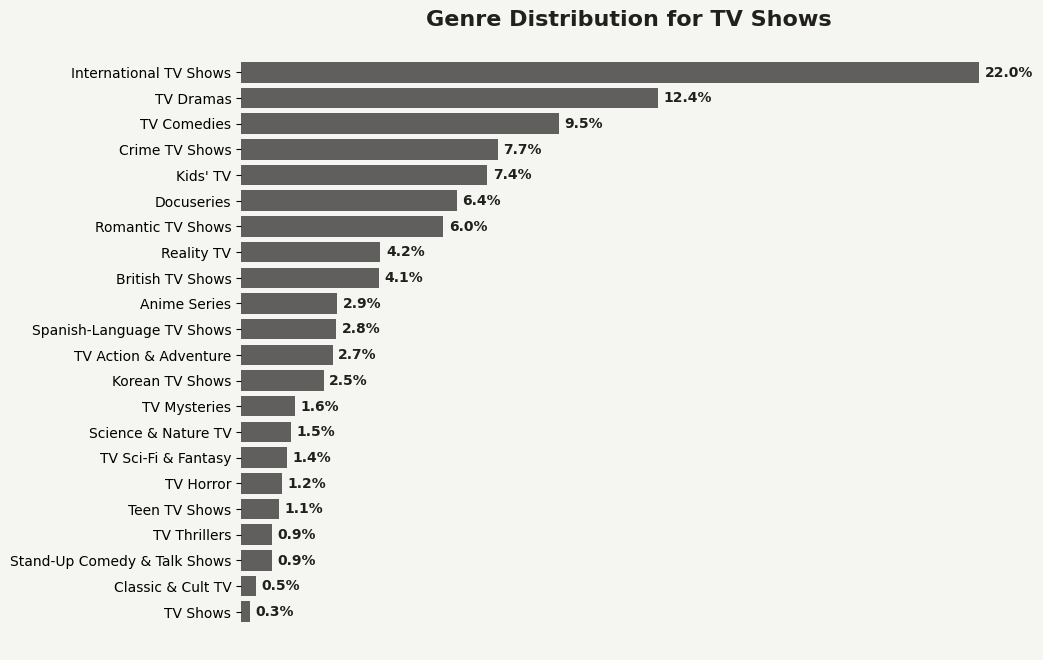

In [ ]:
def plot_genre(data, title, color):
    fig, ax = plt.subplots(figsize=(10, 8))
    fig.patch.set_facecolor('#F5F5F1')
    ax.set_facecolor('#F5F5F1')
    bars = ax.barh(data['genere'], data['count'], color='#221F1F', alpha=0.7)
    ax.set_title(title, fontsize=20, fontweight='bold', color='#221F1F')  # Ubah ukuran dan warna judul
    ax.set_title(title, fontsize=16, fontweight='bold')

    total = data['count'].sum()
    # Adding label in the right of the bar
    for bar in bars:
        percentage = bar.get_width() / total * 100
        plt.text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2,
                 f'{percentage:.1f}%',
                 va='center', ha='left', fontsize=10, color='#221F1F', fontweight='bold')

    # Hilangkan spines (garis pinggir)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # Hilangkan angka grid di sumbu x
    ax.xaxis.set_ticks([])

    plt.show()

# Genre plot for TV Show
plot_genre(tv_genere, 'Genre Distribution for TV Shows', '#ff7f0e')



> The most 3 common genre on both Movies and TV Shows are **International, Dramas, and Comedies**.



##Actors liked by Netflix and its users

Is there any actor liked by Netflix and its loyal users? How can we use their strategy into our Streamflicks?

In [ ]:
cast = netflix[['cast', 'type', 'title']]
cast_names = cast['cast']


names_dict = {}

for names in cast_names:
    names = names.split(',')
    for name in names:
        if name in names_dict.keys():
            d = {}
            d[name] = names_dict[name] + 1
            names_dict.update(d)
        else:
            d = {}
            d[name] = 1
            names_dict.update(d)

actor, roles = [], []
for key, value in names_dict.items():
    actor.append(key)
    roles.append(value)

cast_temp = (pd.DataFrame({'Actor':actor, 'Roles':roles})
             .sort_values('Roles', ascending = False))
cast_temp.reset_index(drop = True, inplace = True)

<ipython-input-146-918d3631c806>:14: UserWarning:

FixedFormatter should only be used together with FixedLocator



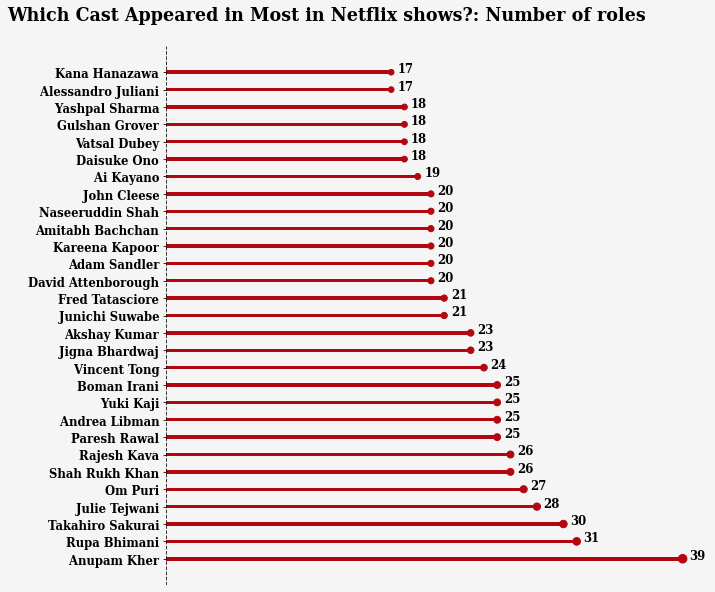

In [ ]:
cast_temp = cast_temp.sort_values(by = 'Roles', ascending = False).reset_index(drop = True)
fig,ax = plt.subplots(figsize =(10,10),dpi = 70)
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')

ax.barh(y = cast_temp.Actor[1:30], width =  cast_temp.Roles[1:30], height = 0.2, color = colors[0])
ax.scatter(y = cast_temp.Actor[1:30], x =  cast_temp.Roles[1:30], s = (cast_temp.Roles[1:30]) *2, c = colors[0] )
ax.axvline(x = 0, ymin = 0,ymax = 1, **{'linewidth':1, 'linestyle':'--', 'color':'black'}, alpha = 0.8)

for i, j in zip(cast_temp.Roles[1:30], cast_temp.Actor[1:30]):
    ax.text(i+0.5,j,i,{'font':'serif', 'size':12,'weight':'bold'})


ax.set_yticklabels(cast_temp.Actor[1:30], fontdict={'fontname': 'serif', 'size': 12, 'weight': 'bold'})
ax.set_xticklabels(labels = [])
ax.set_xticks(ticks = [])

ax.text(-12, 31, 'Which Cast Appeared in Most in Netflix shows?: Number of roles',{'font':'serif', 'size':18,'weight':'bold'})
plt.box(None)

fig.show()

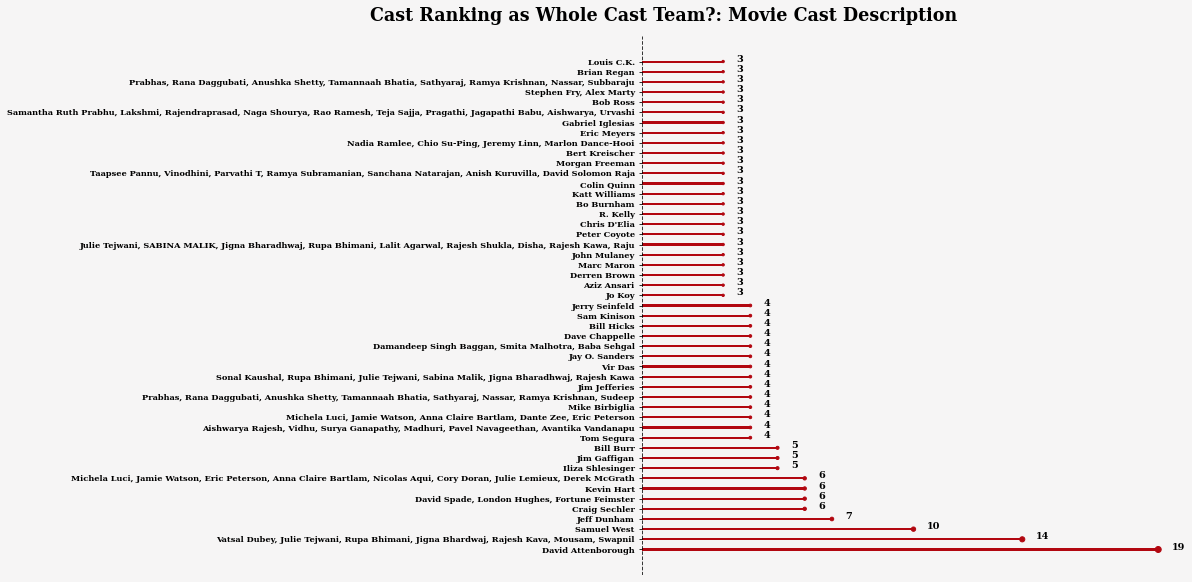

In [ ]:
cast_single = cast.cast.value_counts()
x = cast_single[1:50].index,
y = cast_single[1:50].values

fig,ax = plt.subplots(figsize =(10,10),dpi = 70)
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')

ax.barh(y = range(1,50), width =  y, height = 0.2, color = colors[0])
ax.scatter(y = range(1,50), x =  y, s = (y) *2, c = colors[0] )
ax.axvline(x = 0, ymin = 0,ymax = 1, **{'linewidth':1, 'linestyle':'--', 'color':'black'}, alpha = 0.8)

for i, j in zip(y,range(1,50)):
    ax.text(i+0.5,j,i,{'font':'serif', 'size':10,'weight':'bold'})

ax.set_yticks(ticks = range(1,50))
ax.set_yticklabels(x[0].tolist()[0:50], fontdict={'font': 'serif', 'size': 8.5, 'weight': 'bold'})
ax.set_xticklabels(labels = [])
ax.set_xticks(ticks = [])

ax.text(-10, 53, 'Cast Ranking as Whole Cast Team?: Movie Cast Description',{'font':'serif', 'size':18,'weight':'bold'})
plt.box(None)

fig.show()



> Anumpam Kher is the most appeared actor in Netflix show. He is senior actor from India.



> Cast ranking as the entire movie cast team is held by David Attenborough with a total of 19 appearances.





#**Recommendation from EDA**



> Here's our final recommendations from Netflix Exploratory Data Analysis that we should bring to our company, **StreamFlicks'**:

    1.   

    2.   

    3.   

    4.   

    5.

    6.

    7.












#**Thank You!!🙋🏻‍♂️🙆🏻‍♀️**

This notebook is developed due to our Final Capstone Project requirements..

Feel so happy and grateful if you enjoy to explore our analysis on Netflix!

Our team members:
1. Wilyvin Tanvee
2. Lilyana Wydianti
3. Ira Salsabilla
4. Revi Siti Nurazizah
5. Fatichah Fitriana